In [1]:
from fastai.vision import *
from PIL import Image
import torchvision
import matplotlib.pyplot as plt
import json

import torch
import torch.nn as nn
import torch.nn.functional as F 

from fastai.layers import FlattenedLoss

from collections import defaultdict, OrderedDict

from os import mkdir, environ # just for my use to access environment variables, not required
from os.path import exists

In [2]:
## edit these for your system
ROOT = Path( "{}/data/streetstyle".format( environ["FASHION_DIR"] ) ) # optional
IMAGES_PATH = ROOT/"streetstyle27k_cropped"
TRAIN_CSV = ROOT/"ss27k_labels_train.csv"
MODEL_SAVE_DIR = ROOT/"models"
RESULTS_DIR = MODEL_SAVE_DIR/"results"
MODEL_SAVE_NAME = "ss27k_resnet34_focalloss_a2_ignored_na" # will be the first part of all saved files

# optionally use validation and test csvs for reproducibility
# this will ignore the val_pct and test_pct options
# you will also have to modify the build_databunch() call to include these
# with val_df = ... and test_df = ...
VAL_CSV = ROOT/"ss27k_labels_val.csv"
TEST_CSV = ROOT/"ss27k_labels_test.csv"

# these can all be changed either here on in the call to build_databunch
bs = 120
im_size = 224
val_pct = 0.1
test_pct = 0.1

# random seed
seed = 42

# set this if you have a rtx card, can sometimes be faster and also allows you to have larger batch sizes
use_fp16 = False

In [102]:
import gc

gc.collect()
del learn
del data
torch.cuda.empty_cache()

In [3]:
df = pd.read_csv( TRAIN_CSV ).sample( frac=1, random_state=seed )
df.head()

,image,label
7821,9de5c2d295c58c3002e3bffa8aabd129_9044728743501...,clothing_pattern_solid major_color_no_label we...
17832,aceb56daaa531e5a5d0b490efdd617dc_9282060146824...,clothing_pattern_graphics major_color_black we...
10815,1e98fc7536975e5ef619688c32b2fba3_5077049134685...,clothing_pattern_solid major_color_white weari...
9926,ba6d75a3bc2c24017a8f237224db9d6d_6888777001097...,clothing_pattern_solid major_color_white weari...
4699,9544f870d2da4b18660bbedcfef55270_8608870251365...,clothing_pattern_solid major_color_no_label we...


In [4]:
val_df = pd.read_csv( VAL_CSV ).sample( frac=1, random_state=seed )
test_df = pd.read_csv( TEST_CSV ).sample( frac=1, random_state=seed )

In [5]:
def build_databunch( df, val_df=None, test_df=None, val_p=val_pct, test_p=test_pct, batch=bs, size=im_size ):
    def _remove_na_labels( lab ):
        new_lab = []
        for i in lab.split( " " ):
            if "no_label" not in i:
                new_lab.append( i )

        return " ".join( new_lab )
    
    val_len, test_len = 0, 0
    
    if test_df is None:
        test_len = int( len( df ) * test_p )
        test_df = df[:test_len]
    
    if val_df is None:
        val_len = int( len( df ) * val_p )
        val_df = df[test_len:test_len+val_len]
           
    train_df = df[test_len+val_len:]
    
    train_df["label"] = train_df["label"].apply( _remove_na_labels )
    val_df["label"] = val_df["label"].apply( _remove_na_labels )
    test_df["label"] = test_df["label"].apply( _remove_na_labels )

    data = ( ImageList.from_df( df=train_df, path=IMAGES_PATH )
                .split_none()
                .label_from_df( label_delim=' ' ) )
    val_data = ( ImageList.from_df( df=val_df, path=IMAGES_PATH )
                .split_none()
                .label_from_df( label_delim=' ' ) )
    test_data = ( ImageList.from_df( df=test_df, path=IMAGES_PATH )
                .split_none()
                .label_from_df( label_delim=' ' ) )
    
    data.valid = val_data.train
    data.test = test_data.train
    
    ds_tfms = get_transforms()
    data = ( data.transform( ds_tfms, size=im_size )
             .databunch( bs=batch ).normalize( imagenet_stats ) )
    
    print( len( train_df ), len( val_df ), len( test_df ) )
        
    return data, train_df

In [6]:
# taken from the previous cohort

class FocalLoss_v2(nn.Module):
    """
    Taken from https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/65938
    """
    def __init__(self, bs, split_list, alpha=1, gamma=2 ):
        super(FocalLoss_v2, self).__init__()
        self.batch = bs
        self.alpha = alpha
        self.gamma = gamma
        
        self.split_list = split_list
        self.n_class = sum( split_list )
        self.split_index = np.zeros( len( self.split_list ) )
        for n, i in enumerate( self.split_list[:-1] ):
            self.split_index[n+1] = self.split_index[n] + i
            
        self.loss_mask = torch.ones( self.batch * self.n_class ).cuda()

    def forward(self, inputs, targets, reduction = 'mean'):
        for batch_n, batch in enumerate( torch.chunk( targets, self.batch ) ):
            for label_n, label in enumerate( torch.split( batch, self.split_list ) ):
                tsum = torch.sum( label )
                
                label_start = self.split_index[label_n]
                cur_batch = batch_n*self.n_class
                label_size = len( label )

                start_pos = int(cur_batch+label_start)

                self.loss_mask[start_pos:start_pos+label_size] = tsum
        
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none' )
        
        pt = torch.exp(-BCE_loss)
        
        alpha_t = (self.alpha - 1) * targets + 1
        
        loss = alpha_t * (1-pt)**self.gamma * BCE_loss
        loss = self.loss_mask * loss

        if reduction =='none' or reduction is None:
            return loss
        elif reduction =='mean':
            return loss.mean()
        elif reduction=='sum':
            return loss.sum()
        else:
            raise NotImplementedError

def focal_flat_loss(*args, **kwargs):
    return FlattenedLoss(FocalLoss_v2, *args, is_2d = False, **kwargs)

In [7]:
data, train_df_split = build_databunch( df, val_df=val_df, test_df=test_df )

20166 2520 2521


In [8]:
cats = [ "major_color", "sleeve_length", "clothing_pattern", "neckline_shape", 
        "clothing_category", "multiple_layers", "wearing_necktie", 
        "collar_presence", "wearing_scarf", "wearing_jacket", 
        "wearing_hat", "wearing_glasses" ]

In [9]:
idx_to_cat = [0] * len( data.classes )
for i, cat in enumerate( cats ):
    for n, label in enumerate( data.classes ):
        if cat in label:
            idx_to_cat[n] = i

def split_to_label_pred( preds ):
    cat_preds = defaultdict( list )
    for n, pred in enumerate( preds ):
        cat = cats[idx_to_cat[n]]
        try:
            cat_preds[cat].append( float( pred ) )
        except ValueError:
            cat_preds[cat].append( pred )
    
    cat_preds = { k: np.array( v ) for k, v in cat_preds.items() }
    return cat_preds

In [10]:
split_list_tmp = { k: len( v ) for k, v in split_to_label_pred( data.classes ).items() }
split_list = np.zeros( len( cats ), dtype=int )
for n, ( k, v ) in enumerate( split_list_tmp.items() ):
    for i in data.classes:
        if k in i:
            split_list[n] = int(v)
            break
split_list = tuple( split_list )

In [11]:
arch = models.resnet34
threshold = 0.15
acc = partial( accuracy_thresh, thresh=threshold )
f_score = partial( fbeta, thresh=threshold )
learn = cnn_learner( data, arch, metrics=[acc, f_score] )
learn.loss_func = focal_flat_loss( bs=bs, split_list=split_list, gamma = 2, alpha = 2 )

if use_fp16:
    learn = learn.to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


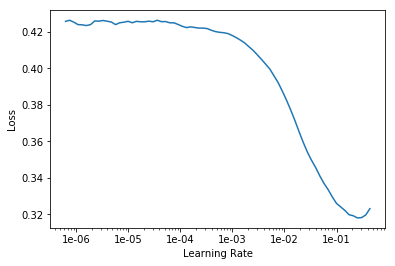

In [12]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [13]:
learn.fit_one_cycle( 4, max_lr=slice(1e-2) )
learn.save( MODEL_SAVE_DIR/"{}_step1".format( MODEL_SAVE_NAME ) )

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.125937,0.089184,0.382307,0.653898,01:11
1,0.093403,0.077538,0.408601,0.664322,01:04
2,0.083934,0.071517,0.424689,0.670641,01:04
3,0.081093,0.070257,0.424180,0.670545,01:04


/home/lewis/.pyenvs/fellowshipai_brands/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FocalLoss_v2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


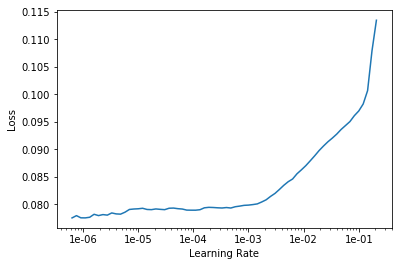

In [14]:
learn.load( MODEL_SAVE_DIR/"{}_step1".format( MODEL_SAVE_NAME ) )
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [15]:
learn.load( MODEL_SAVE_DIR/"{}_step1".format( MODEL_SAVE_NAME ) )
learn.unfreeze()
learn.fit_one_cycle( 6, max_lr=slice(5e-5, 5e-4) )
learn.save( MODEL_SAVE_DIR/"{}_step2".format( MODEL_SAVE_NAME ) )

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.076692,0.065618,0.445212,0.678769,01:23
1,0.072435,0.061950,0.466382,0.687584,01:23
2,0.068364,0.058717,0.487026,0.696362,01:23
3,0.063991,0.054389,0.524405,0.712390,01:24
4,0.059695,0.052839,0.535542,0.716747,01:23
5,0.057326,0.052333,0.539156,0.718387,01:23


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


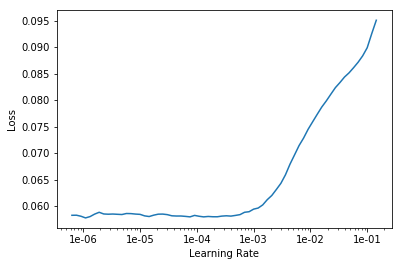

In [16]:
learn.load( MODEL_SAVE_DIR/"{}_step2".format( MODEL_SAVE_NAME ) )
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [17]:
learn.load( MODEL_SAVE_DIR/"{}_step2".format( MODEL_SAVE_NAME ) )
learn.unfreeze()
learn.fit_one_cycle( 5, max_lr=slice(1e-7, 1e-6) )
learn.save( MODEL_SAVE_DIR/"{}_step3".format( MODEL_SAVE_NAME ) )

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.056652,0.052282,0.535274,0.716717,01:23
1,0.057441,0.052303,0.531884,0.715255,01:23
2,0.056588,0.052274,0.532660,0.715555,01:24
3,0.057158,0.052204,0.536482,0.717273,01:24
4,0.056926,0.052251,0.543237,0.720207,01:24


In [18]:
learn.load( MODEL_SAVE_DIR/"{}_step3".format( MODEL_SAVE_NAME ) )

if use_fp16:
    learn = learn.to_fp32()

In [21]:
probs, ys = learn.get_preds( ds_type=DatasetType.Test )
probs = probs.sigmoid()

In [33]:
class NestedContinue(Exception): pass

thres = 0

pred_eg = split_to_label_pred( ys[0] )
performance = { k: [ 0.0, 0 ] for k in cats }
performance_per_label = { k: OrderedDict( [ ( v, [ 0.0, 0 ] ) for v in data.classes if k in v ] ) for k in cats }
performance_per_label_idx = { k: list( v.items() ) for k, v in performance_per_label.items() }

skipped = 0
for prob, y in zip( probs, ys ):
    prob, y = split_to_label_pred( prob ), split_to_label_pred( y )
    try:
        for cat in cats:
            prob_cat, y_cat = prob[cat], y[cat]

            if np.sum( y_cat ) == 0:
                raise NestedContinue

            if thres:
                prob_cat -= [ prob if prob <= thres else 0 for prob in prob_cat ]

            argmax = np.argmax( prob_cat )
            y_argmax = np.argmax( y_cat )
            label = performance_per_label_idx[cat][y_argmax][0]

            if argmax == y_argmax and prob_cat[argmax] > 0.0:            
                performance_per_label[cat][label][0] += 1.0
                performance[cat][0] += 1.0

            performance_per_label[cat][label][1] += 1.0
            performance[cat][1] += 1.0
    except NestedContinue:
        skipped += 1
        continue

for k, v in performance.items():
    performance[k] = v[0]/v[1]
    
    for k2, v2 in performance_per_label[k].items():
        try:
            performance_per_label[k][k2] = v2[0]/v2[1]
        except:
            performance_per_label[k][k2] = 0
            
print( len( ys ), skipped )

2521 1435


['clothing_category_t-shirt', 'clothing_pattern_graphics', 'collar_presence_no', 'major_color_white', 'multiple_layers_one_layer', 'neckline_shape_round', 'sleeve_length_short_sleeve', 'wearing_glasses_yes', 'wearing_hat_no', 'wearing_jacket_no', 'wearing_necktie_no', 'wearing_scarf_no']


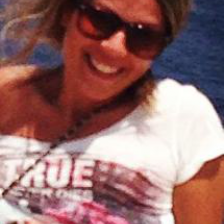

In [106]:
from IPython.core.display import display

im = learn.data.test_ds[25]
lab, ys, x = learn.predict( im[0] )
catmax = { k: np.argmax( v ) for k, v in split_to_label_pred( x ).items() }
cat_subs = split_to_label_pred( data.classes )
catmax = [ cat_subs[k][v] for k, v in catmax.items() ]
print( catmax )

display( im[0] )

In [30]:
performance

{'major_color': 0.7542120911793855,
 'sleeve_length': 0.808792372881356,
 'clothing_pattern': 0.8773747841105354,
 'neckline_shape': 0.8700361010830325,
 'clothing_category': 0.7619047619047619,
 'multiple_layers': 0.9045571797076526,
 'wearing_necktie': 0.9809853068280034,
 'collar_presence': 0.9115523465703971,
 'wearing_scarf': 0.9873073436083409,
 'wearing_jacket': 0.9361313868613139,
 'wearing_hat': 0.93327239488117,
 'wearing_glasses': 0.988950276243094}

In [28]:
performance_per_label

{'major_color': OrderedDict([('major_color_black', 0.9290220820189274),
              ('major_color_blue', 0.7108433734939759),
              ('major_color_brown', 0.23684210526315788),
              ('major_color_cyan', 0.0),
              ('major_color_gray', 0.42207792207792205),
              ('major_color_green', 0.6122448979591837),
              ('major_color_multicolored', 0.5020576131687243),
              ('major_color_orange', 0.3333333333333333),
              ('major_color_pink', 0.5357142857142857),
              ('major_color_purple', 0.0),
              ('major_color_red', 0.8415841584158416),
              ('major_color_white', 0.9156908665105387),
              ('major_color_yellow', 0.5128205128205128)]),
 'sleeve_length': OrderedDict([('sleeve_length_long_sleeve',
               0.8829787234042553),
              ('sleeve_length_no_sleeve', 0.8323170731707317),
              ('sleeve_length_short_sleeve', 0.6469719350073855)]),
 'clothing_pattern': OrderedDict([('cl

In [34]:
def save_results( perf, perf_per_label ):
    if not ( exists( RESULTS_DIR ) ):
        mkdir( RESULTS_DIR )
        
    perf_per_label = { k2: v2 for k, v in perf_per_label.items() for k2, v2 in v.items() }
    
    j_perf, j_perf_per = json.dumps( perf ), json.dumps( perf_per_label )
    with open( RESULTS_DIR/"{}_perf.json".format( MODEL_SAVE_NAME ), "w" ) as f:
        f.write( j_perf )
        
    with open( RESULTS_DIR/"{}_perf_per_label.json".format( MODEL_SAVE_NAME ), "w" ) as f:
        f.write( j_perf_per )
        
def compare_results( other, this=None, mode='perf' ):
    if this is None:
        this = MODEL_SAVE_NAME
        if mode == 'perf':
            perf = performance
        elif mode == 'perf_per_label':
            perf = performance_per_label
    else:
        with open( RESULTS_DIR/"{}_{}.json".format( this, mode ), "r" ) as f:
            perf = json.load( f )
            
    with open( RESULTS_DIR/"{}_{}.json".format( other, mode ), "r" ) as f:
            perf2 = json.load( f )
            
    for k, v in perf.items():
        perf1_score = round( v*100, 1 )
        perf2_score = round( perf2[k]*100, 1 )
        diff = round( perf1_score - perf2_score, 2 )
            
        print( "Label '{}', {} scores {}%, {} scores {}%, {} {} by {}%\n".format(
            k, this, perf1_score, other, perf2_score, this,"better" if diff > 0 else "worse", diff )  )

In [35]:
save_results( performance, performance_per_label )

In [36]:
performance_per_label = { k2: v2 for k, v in performance_per_label.items() for k2, v2 in v.items() }

In [37]:
compare_results( "ss27k_resnet34_focalloss_a2_removed_na", mode="perf" )

Label 'major_color', ss27k_resnet34_focalloss_a2_ignored_na scores 75.4%, ss27k_resnet34_focalloss_a2_removed_na scores 67.5%, ss27k_resnet34_focalloss_a2_ignored_na better by 7.9%

Label 'sleeve_length', ss27k_resnet34_focalloss_a2_ignored_na scores 80.9%, ss27k_resnet34_focalloss_a2_removed_na scores 78.4%, ss27k_resnet34_focalloss_a2_ignored_na better by 2.5%

Label 'clothing_pattern', ss27k_resnet34_focalloss_a2_ignored_na scores 87.7%, ss27k_resnet34_focalloss_a2_removed_na scores 77.3%, ss27k_resnet34_focalloss_a2_ignored_na better by 10.4%

Label 'neckline_shape', ss27k_resnet34_focalloss_a2_ignored_na scores 87.0%, ss27k_resnet34_focalloss_a2_removed_na scores 74.9%, ss27k_resnet34_focalloss_a2_ignored_na better by 12.1%

Label 'clothing_category', ss27k_resnet34_focalloss_a2_ignored_na scores 76.2%, ss27k_resnet34_focalloss_a2_removed_na scores 62.9%, ss27k_resnet34_focalloss_a2_ignored_na better by 13.3%

Label 'multiple_layers', ss27k_resnet34_focalloss_a2_ignored_na scores 